In [10]:
import os
import argparse
import yaml
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
%matplotlib inline

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from models import get_model
from utils import trust_scores
from metrics import Metrics
import utils.logger
LOGGER = utils.logger.get_logger(__name__, level='DEBUG')

## Load normal model

In [2]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/camvid/camvid_segnet_baseline_pretrained_dropout/config_1.yaml'
epoch = 326
mode = 'normal'

# Dataloader
with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']
    if config_args['training']['learner'] in ['segmentation', 'selfconfid-segmentation']:
        config_args['training']['metrics'].append('mean_iou')

config_args['data']['is_test'] = True
config_args['model']['feature_dim'] = 512

# Special case of MC Dropout
if mode == 'mc_dropout':
    config_args['training']['mc_dropout'] = True
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
LOGGER.info('Loading dataset {}'.format(config_args['data']['dataset']))
dloader = get_loader(config_args, generating=True)

# Make loaders
dloader.make_loaders()

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_normal = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_normal.model.load_state_dict(checkpoint['model_state_dict'])

# Get scores
LOGGER.info('Inference mode: {}'.format(mode))

if not hasattr(checkpoint, 'prod_test_len'):
    learner_normal.prod_test_len = learner_normal.nsamples_test

2019-05-21 11:19:43,221 gpuserver2 __main__[28582] INFO Loading dataset camvid
2019-05-21 11:19:43,222 gpuserver2 loaders.loader[28582] INFO --- Augmentations ---
2019-05-21 11:19:43,223 gpuserver2 augmentations[28582] INFO Using hflip aug with params True
2019-05-21 11:19:43,238 gpuserver2 __main__[28582] WARNING Learning type: segmentation


fetched 367 images from text file
fetched 101 images from text file
fetched 233 images from text file


2019-05-21 11:19:46,124 gpuserver2 learners.learner[28582] INFO Using optimizer adam
2019-05-21 11:19:46,126 gpuserver2 schedulers[28582] INFO Using No LR Scheduling
2019-05-21 11:19:46,622 gpuserver2 __main__[28582] INFO Inference mode: normal


## Load selfconfid model

In [3]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/camvid/paper/camvid_segnet_selfconfid_k3_adam_lr4_mse/config_1.yaml'
epoch = 386

with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']
    if config_args['training']['learner'] in ['segmentation', 'selfconfid-segmentation']:
        config_args['training']['metrics'].append('mean_iou')
        
config_args['model']['feature_dim'] = 512

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_selfconfid = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_selfconfid.model.load_state_dict(checkpoint['model_state_dict'])

if not hasattr(learner_selfconfid, 'prod_test_len'):
    learner_selfconfid.prod_test_len = learner_selfconfid.nsamples_test

2019-05-21 11:19:46,639 gpuserver2 __main__[28582] WARNING Learning type: selfconfid-segmentation
2019-05-21 11:19:46,995 gpuserver2 learners.learner[28582] INFO Using optimizer adam
2019-05-21 11:19:46,996 gpuserver2 schedulers[28582] INFO Using No LR Scheduling
2019-05-21 11:19:47,103 gpuserver2 learners.segmentation_selfconfid_learner[28582] INFO Freezing every layer except uncertainty
2019-05-21 11:19:47,105 gpuserver2 learners.segmentation_selfconfid_learner[28582] INFO Keeping original BN parameters


uncertainty1.weight kept to training
uncertainty1.bias kept to training
uncertainty2.weight kept to training
uncertainty2.bias kept to training
uncertainty3.weight kept to training
uncertainty3.bias kept to training
uncertainty4.weight kept to training
uncertainty4.bias kept to training
uncertainty5.weight kept to training
uncertainty5.bias kept to training
down1.conv1.cbr_unit.1 original BN setting
down1.conv2.cbr_unit.1 original BN setting
down2.conv1.cbr_unit.1 original BN setting
down2.conv2.cbr_unit.1 original BN setting
down3.conv1.cbr_unit.1 original BN setting
down3.conv2.cbr_unit.1 original BN setting
down3.conv3.cbr_unit.1 original BN setting
dropout_down3 set to eval mode
down4.conv1.cbr_unit.1 original BN setting
down4.conv2.cbr_unit.1 original BN setting
down4.conv3.cbr_unit.1 original BN setting
dropout_down4 set to eval mode
down5.conv1.cbr_unit.1 original BN setting
down5.conv2.cbr_unit.1 original BN setting
down5.conv3.cbr_unit.1 original BN setting
dropout_down5 set t

## Show image

In [58]:
# Load test batch
for batch_id, (input_img, target_class) in enumerate(dloader.test_loader):
    if batch_id==0:
        break

In [59]:
# Normal
learner_normal.model.eval()
output = learner_normal.model(input_img.to(device))
probs_normal = F.softmax(output, dim=1)
confidence_normal, pred_normal = probs_normal.max(dim=1, keepdim=True)
confidence_normal = confidence_normal.detach().cpu()
pred_normal = pred_normal.detach().cpu()

output, probs_normal = None, None
torch.cuda.empty_cache()

In [60]:
learner_selfconfid.model.eval()
_, confidence_selfconfid = learner_selfconfid.model(input_img.to(device))
confidence_selfconfid = torch.sigmoid(confidence_selfconfid).detach().cpu().squeeze(0)
torch.cuda.empty_cache()

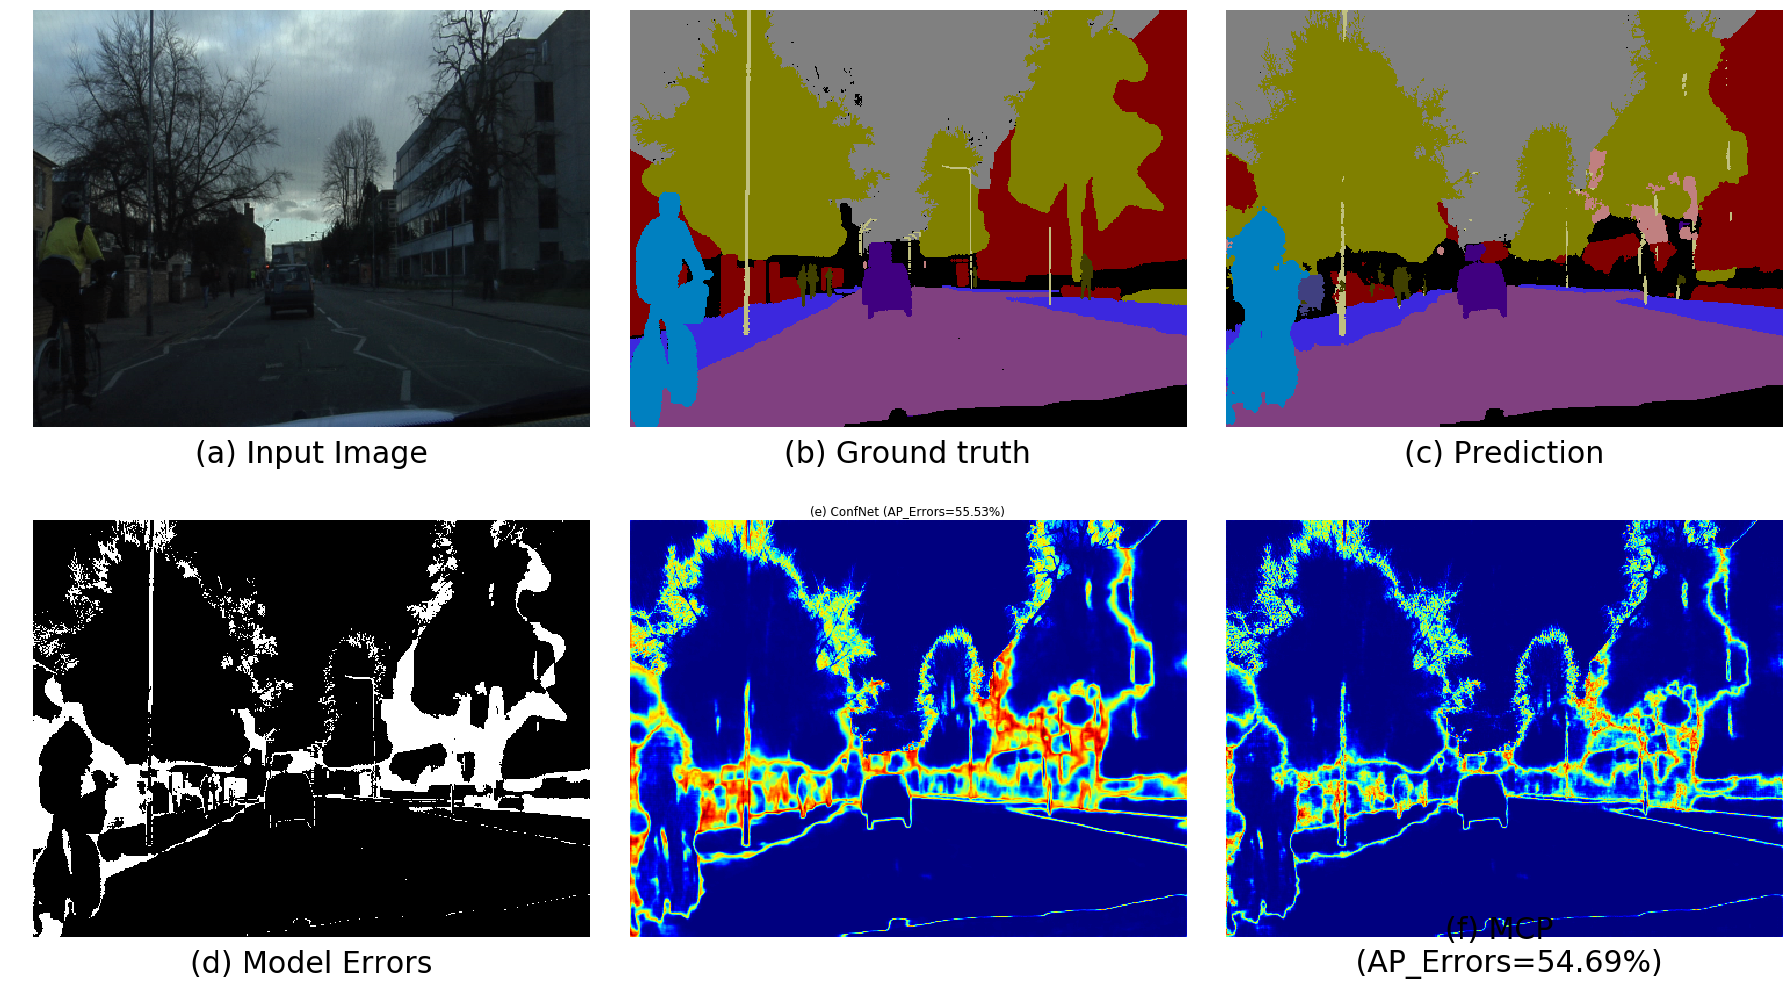

In [87]:
i = 3
raw_image = dloader.test_loader.dataset.unprocess_image(input_img[i].detach().cpu().squeeze(0))

plt.figure(figsize=(25,15))
plt.subplot(231)
plt.title('(a) Input Image', y=-0.1, fontsize=30)
plt.axis('off')
plt.imshow(raw_image)
plt.subplot(232)
plt.title('(b) Ground truth', y=-0.1, fontsize=30)
plt.axis('off')
plt.imshow(dloader.test_loader.dataset.decode_segmap(target_class[i], plot=False))
plt.subplot(233)
plt.title('(c) Prediction', y=-0.1, fontsize=30)
plt.axis('off')
plt.imshow(dloader.test_loader.dataset.decode_segmap(pred_normal[i].squeeze(0), plot=False))
plt.tight_layout()

plt.subplot(234)
plt.axis('off')
plt.title('(d) Model Errors', y=-0.1, fontsize=30)
plt.imshow((pred_normal[i]!=target_class[i]).squeeze(0), cmap=plt.cm.gray)
plt.subplot(235)
#plt.title('(e) ConfNet ', y=-0.1, fontsize=30) 
plt.title('(e) ConfNet \n AP_Errors={:05.2%}'.format(average_precision_score((pred_normal[i]!=target_class[i]).squeeze(0), -confidence_selfconfid[i].squeeze(0)), 
                                                     y=-0.1, fontsize=30))
plt.axis('off')
plt.imshow(-confidence_selfconfid[i].squeeze(0), cmap=plt.cm.get_cmap('jet'))
plt.subplot(236)
#plt.title('(f) MCP', y=-0.1, fontsize=30)
plt.title('(f) MCP \n AP_Errors={:05.2%}'.format(average_precision_score((pred_normal[i]!=target_class[i]).squeeze(0),-confidence_normal[i].squeeze(0)), 
                                                 y=-0.1, fontsize=30)
plt.axis('off')
plt.imshow(-confidence_normal[i].squeeze(0),  cmap=plt.cm.get_cmap('jet'))
plt.tight_layout()

In [56]:
loop = tqdm(dloader.test_loader)
diff = []
for batch_id, (data, target) in enumerate(loop):
    print('###############')
    print(batch_id)
    # Normal
    learner_normal.model.eval()
    output = learner_normal.model(data.to(device))
    probs_normal = F.softmax(output, dim=1)
    confidence_normal, pred_normal = probs_normal.max(dim=1, keepdim=True)
    confidence_normal = confidence_normal.detach().cpu()
    pred_normal = pred_normal.detach().cpu()

    output, probs_normal = None, None
    torch.cuda.empty_cache()

    learner_selfconfid.model.eval()
    _, confidence_selfconfid = learner_selfconfid.model(data.to(device))
    confidence_selfconfid = torch.sigmoid(confidence_selfconfid).detach().cpu().squeeze(0)
    torch.cuda.empty_cache()

    for i in range(len(data)):
        ape_normal = average_precision_score((pred_normal[i]!=target_class[i]).squeeze(0), 
                                             -confidence_normal[i].squeeze(0))
        ape_selfconfid = average_precision_score((pred_normal[i]!=target_class[i]).squeeze(0), 
                                             -confidence_selfconfid[i].squeeze(0))
        diff.append(ape_selfconfid-ape_normal)
        print(i)
        print('{:05.2%}'.format(ape_selfconfid-ape_normal))
        print('----')

###############
0
0
-0.44%
----
1
0.27%
----
2
0.74%
----
3
2.60%
----
4
1.56%
----
5
0.35%
----
6
-0.28%
----
7
0.52%
----
###############
1
0
-0.73%
----
1
0.94%
----
2
-0.13%
----
3
0.31%
----
4
0.66%
----
5
-0.65%
----
6
-0.93%
----
7
-0.78%
----
###############
2
0
0nan%
----
1
-2.13%
----
2
0.15%
----
3
-1.13%
----
4
0.67%
----
5
0nan%
----
6
0.15%
----
7
0nan%
----
###############
3
0
-0.48%
----
1
0.00%
----
2
0.16%
----
3
0.96%
----
4
-0.34%
----
5
-0.51%
----
6
0.26%
----
7
-0.38%
----
###############
4
0
0.31%
----
1
0.35%
----
2
0.19%
----
3
0.29%
----
4
0.54%
----
5
-0.14%
----
6
1.24%
----
7
-0.41%
----
###############
5
0
-0.57%
----
1
0.81%
----
2
1.87%
----
3
1.10%
----
4
1.11%
----
5
0.84%
----
6
1.56%
----
7
-0.66%
----
###############
6
0
-1.27%
----
1
-1.45%
----
2
0.02%
----
3
2.89%
----
4
2.85%
----
5
1.31%
----
6
1.97%
----
7
1.42%
----
###############
7
0
0.94%
----
1
-0.55%
----
2
-0.02%
----
3
0.48%
----
4
1.03%
----
5
1.45%
----
6
1.21%
----
7
0.90%
----
###

KeyboardInterrupt: 